# Forecast verification
Here I use climpred to setup and verify the forecasts.

The most daunting task is aligning the original dataset with the data format expected by climpred.

Some terminology, as retrieved from [here](https://climpred.readthedocs
.io/en/stable/).
* **initialized ensemble** the hindcast or forecast DataSet which includes the members
* **member** a member of an ensemble (forecast)
* See more terminology guidance [here](https://climpred.readthedocs.io/en/stable/terminology.html)

[Note](https://youtu.be/EcMxImmMBec?t=8526) more than one verification dataset can be carried along! This allows to compare the skill for multiple observational datasets.

[Note](https://youtu.be/EcMxImmMBec?t=8647) a skill dimension is appended to the HindcastEnsemble object which allows to compare the skills of the forecast product and the skill of the reference forecast (e.g. persistence) -> good plot of the spatial distribution of skill in two rows, one for the forecast product and the other one for the reference product

# TODO Notebook
* add markdown cells before each codecell documenting what I do and test if I
 can re-run the code with the data

* regrid CERRA to common grid with SEAS5 HC
* assign the same dimensions to both
* see "Effective Sample Size" -> should I use it? see https://doi.org/10
.1175/1520-0442(1999)012<1990:TENOSD>2.0.CO;2  Also compute the p values!
Understand how this is used in forecast verification!
* check multiplicative bias https://climpred.readthedocs.io/en/stable/metrics.html#multiplicative-bias

Make sure that your init and lead dimensions align. --> maybe I need to have
the same number of init dates as lead timesteps. Try the xarray align
method!!! See https://climpred.readthedocs.io/en/stable/quick-start.html

https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html#arithmetic-operations-with-predictionensemble-objects
It’s safest to do anything like climatology removal before constructing
climpred objects.
--> just not sure how e.g. the ACC is computed then if we are not even in
anomaly space. Does climpred actually compute anomalies?

I will probably not need to worry about detrending at seasonal timescales...
where is literature which specifies at which time intervals detrending
becomes relevant?

In [50]:
%%time
# set up a local dask cluster for parallelisation and accessing the dashboard
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
# client = Client(address="127.0.0.1:8787")
client

CPU times: total: 109 ms
Wall time: 4.19 s


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55408,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.73 GiB
Comm: tcp://127.0.0.1:55428,Total threads: 2
Dashboard: http://127.0.0.1:55433/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:55413,


In [54]:
import numpy as np
import xarray as xr
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# from verification import get_inits, load_hindcast_data, load_verification_data
# from climpred.preprocessing.shared import set_integer_time_axis
from climpred import HindcastEnsemble

Data amount of ERA5 seems to be OK to handle: 831699 datapoints. Shape (8401, 9, 11)

The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:
-8.940698171500117e-05 

Now the data looks good
Max. daily precipitation: 94.08016967773438
Min. daily precipitation: 0.0 

CPU times: total: 156 ms
Wall time: 537 ms


[Text(0.5, 1.0, 'Histogram over all timesteps and gridpoints.')]

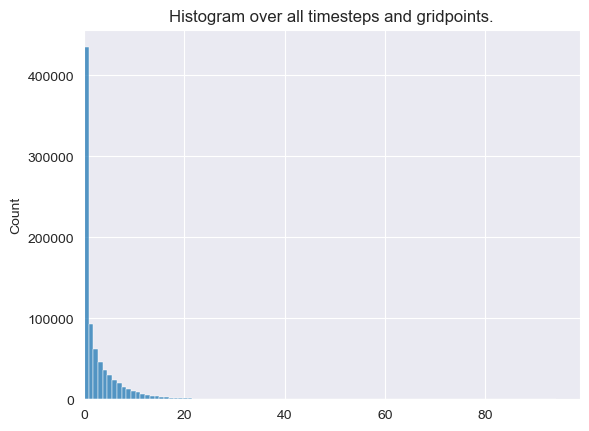

In [66]:
%%time
# Read in quasi-observations from ERA5, which have been (conservatively) regridded from 0.25°x0.25° latlon to 1°x1° latlon (using MPI CDO) and also
# aggregated (sum) from hourly to daily values.
obs = xr.open_dataset(r"C:\Users\sb123\Documents\Massendaten\Observations.nc")["tp"]
print(f"Data amount of ERA5 seems to be OK to handle: {obs.count().values} datapoints. Shape: {obs.shape}\n")
obs = obs * 1000 #Careful: Attrs are dropped when doing basic arithmetics: https://github.com/pydata/xarray/issues/1271
attrs = {"units":"mm", "long_name":"Total precipitation"}
obs.attrs = attrs

print("The ERA5 data still contains some very small negative values, which are replaced with zeros in the next step:")
print(f"{obs.values.min()} \n")

# I did not find a straightforward way of replacing all negative pr values with zeros in Xarray. Hence a little workaround:
# Step 1: All negative values to NAN:
obs = obs.where(obs > 0)
# Step 2: all NaNs to 0:
obs = obs.fillna(0)
# np.unique((obs.where(obs<0) * 0).values)

print("Now the data looks good")
print(f"Max. daily precipitation: {obs.max().values}")
print(f"Min. daily precipitation: {obs.min().values} \n")

fig, ax = plt.subplots()
sns.histplot(obs.values.flat, ax=ax, bins=100)
ax.set_xlim(left=0)
ax.set(title="Histogram over all timesteps and gridpoints.")

In [67]:
%%time
# Now let's have a look at the forecast data:
hc = xr.open_dataset(r"C:\Users\sb123\Documents\Massendaten\hc.nc",chunks="auto")["tp"]
print(f"{hc.count().values} data points... quite a bit of data! Shape: {hc.shape}")
hc = hc * 1000 # Conversion from m to mm
hc.attrs = attrs

# Sanitizing of <0 values as above:
print("Just like the observations the forecasts also contain negative pr values:")
print(f"Min. {hc.min().values} \n")

hc = hc.where(hc > 0)
hc = hc.fillna(0)

print("Check the data after sanitizing:")
print(f"Min.: {hc.min().values}")
print(f"Max.: {hc.max().values}\n")

# fig, ax = plt.subplots()
# sns.histplot(hc.values.flat, ax=ax, bins=100)
# ax.set_xlim(left=0)

146866500 data points... quite a bit of data! Shape: (276, 215, 25, 9, 11)
Just like the observations the forecasts also contain negative pr values:
Min. -0.035703182220458984 

Check the data after sanitizing:
Min.: 0.0
Max.: 1169.189453125

CPU times: total: 469 ms
Wall time: 3.68 s


**Issue**
As we can see in the above histogram something is quite odd with the distribution of the seasonal forecasted precipitation values. The thing is, that I have not really modified the data, as I have only regridded and aggregated the ERA5 data to *match* the SEAS5 data. The data actually comes straight from Copernicus. Let's compare the 1994 - 2016 climatologies for precipiation over both datasets to see if there is a systematic offset.

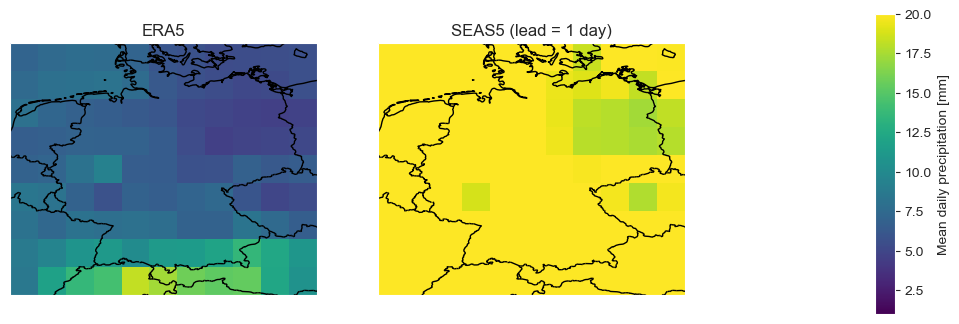

In [102]:

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, ncols=2, figsize=(10,10))
fig.subplots_adjust(right=0.8) #to make space for the colorbar

obs.mean(dim=["time"]).plot(ax=ax[0],vmin=1, vmax=5.5, add_colorbar=False) #TODO resample(time="1Y").sum()
plot = hc.mean(dim=["member", "init"]).sel({"lead":"10 days"}).plot(ax=ax[1],vmin=1, vmax=20, add_colorbar=False) #ensemble and initialisations mean, lead = 1 day
titles = ["ERA5", "SEAS5 (lead = 1 day)"]
for c,axs in enumerate(ax.flat):
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.BORDERS)
    axs.set_title(titles[c])
cbar_ax = fig.add_axes([.99, .35, .02, 0.3])
fig.colorbar(plot, cax=cbar_ax, label=("Mean daily precipitation [mm]"))
# plt.tight_layout()

In [78]:
hc.mean(dim="member").sel({"lead":"1 days"})

<xarray.DataArray 'tp' (init: 276, latitude: 9, longitude: 11)>
dask.array<getitem, shape=(276, 9, 11), dtype=float32, chunksize=(221, 6, 8), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 5.0 6.0 7.0 8.0 9.0 ... 12.0 13.0 14.0 15.0
  * latitude   (latitude) float32 55.0 54.0 53.0 52.0 51.0 50.0 49.0 48.0 47.0
    lead       timedelta64[ns] 1 days
  * init       (init) datetime64[ns] 1994-01-01 1994-02-01 ... 2016-12-01

In [ ]:

# instantiate a climpred HindcastEnsemble object
hindcast = HindcastEnsemble(hc)
hindcast = hindcast.add_observations(obs)

# Testing only:
# hc = hc.assign_coords({"month" : hc.init.dt.month.values}) # for testing to
# filter for inits on a specific month to compare results against https://meteoswiss-climate.shinyapps.io/skill_metrics/
print(hindcast)

In [49]:
# Doing some visualisations and plausibility checks on our climpred
# HindcastEnsemble

# fig, ax = plt.subplots()
data = hindcast.get_observations().tp.values.flat
# import numpy as np
data[np.where(data < 0)[0]]

# sns.histplot(data=hindcast.get_observations().tp.values[:,0,0])

array([-8.9406967e-08, -8.9406967e-08, -6.1200815e-08, ...,
       -8.9406974e-08, -8.9406974e-08, -8.9406967e-08], dtype=float32)

In [22]:
# compute multiplicative bias (i.e. forecast/observations for each lead and
# init) #TODO decide which alignment to use -> literature?
mult_bias = hindcast.verify(metric="multiplicative_bias",comparison="e2o", alignment="same_inits", dim="init")
print(mult_bias)

INFO:root:initialized | lead: 1.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-02 00:00:00-2016-05-02 00:00:00
INFO:root:initialized | lead: 2.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-03 00:00:00-2016-05-03 00:00:00
INFO:root:initialized | lead: 3.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-04 00:00:00-2016-05-04 00:00:00
INFO:root:initialized | lead: 4.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-05 00:00:00-2016-05-05 00:00:00
INFO:root:initialized | lead: 5.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-06 00:00:00-2016-05-06 00:00:00
INFO:root:initialized | lead: 6.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-07 00:00:00-2016-05-07 00:00:00
INFO:root:initialized | lead: 7.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-08 00:00:00-2016-05-08 00:00:00
INFO:root:initialized | lead: 8.0 | inits: 1994-01-01 00:00:00-2016-0

<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 9, lead: 215)
Coordinates:
  * longitude  (longitude) float32 5.0 6.0 7.0 8.0 9.0 ... 12.0 13.0 14.0 15.0
  * latitude   (latitude) float32 55.0 54.0 53.0 52.0 51.0 50.0 49.0 48.0 47.0
  * lead       (lead) float64 1.0 2.0 3.0 4.0 5.0 ... 212.0 213.0 214.0 215.0
    skill      <U11 'initialized'
Data variables:
    tp         (lead, latitude, longitude) float32 dask.array<chunksize=(1, 9, 11), meta=np.ndarray>


In [34]:
# Analyse the  multiplicative bias
# 1. Check dependence of bias on lead time for the whole area. Is there a
# systematic correlation?


AttributeError: 'function' object has no attribute 'values'

In [6]:
%time
#
verification_e2o = hindcast.verify(
    metric="pearson_r", comparison="e2o", dim="init", alignment="same_inits"
)

INFO:root:initialized | lead: 1.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-02 00:00:00-2016-05-02 00:00:00
INFO:root:initialized | lead: 2.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-03 00:00:00-2016-05-03 00:00:00
INFO:root:initialized | lead: 3.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-04 00:00:00-2016-05-04 00:00:00
INFO:root:initialized | lead: 4.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-05 00:00:00-2016-05-05 00:00:00
INFO:root:initialized | lead: 5.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-06 00:00:00-2016-05-06 00:00:00
INFO:root:initialized | lead: 6.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-07 00:00:00-2016-05-07 00:00:00
INFO:root:initialized | lead: 7.0 | inits: 1994-01-01 00:00:00-2016-05-01 00:00:00 | verifs: 1994-01-08 00:00:00-2016-05-08 00:00:00
INFO:root:initialized | lead: 8.0 | inits: 1994-01-01 00:00:00-2016-0

CPU times: total: 51.2 s
Wall time: 1min 20s


In [5]:
verification_e2o

<xarray.Dataset>
Dimensions:    (lead: 215, longitude: 11, latitude: 9, member: 25)
Coordinates:
  * longitude  (longitude) float32 5.0 6.0 7.0 8.0 9.0 ... 12.0 13.0 14.0 15.0
  * latitude   (latitude) float32 55.0 54.0 53.0 52.0 51.0 50.0 49.0 48.0 47.0
  * member     (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * lead       (lead) float64 1.0 2.0 3.0 4.0 5.0 ... 212.0 213.0 214.0 215.0
    skill      <U11 'initialized'
Data variables:
    tp         (lead, longitude, latitude, member) float64 dask.array<chunksize=(1, 11, 9, 25), meta=np.ndarray>

**Check, do I still have a member dimension when verifying with m2o?**

**ToDo:** Also calculate the p - values and research the underlying
methodology (see Wilks 2019)

Da läuft noch was schief mit den Verification Alignments

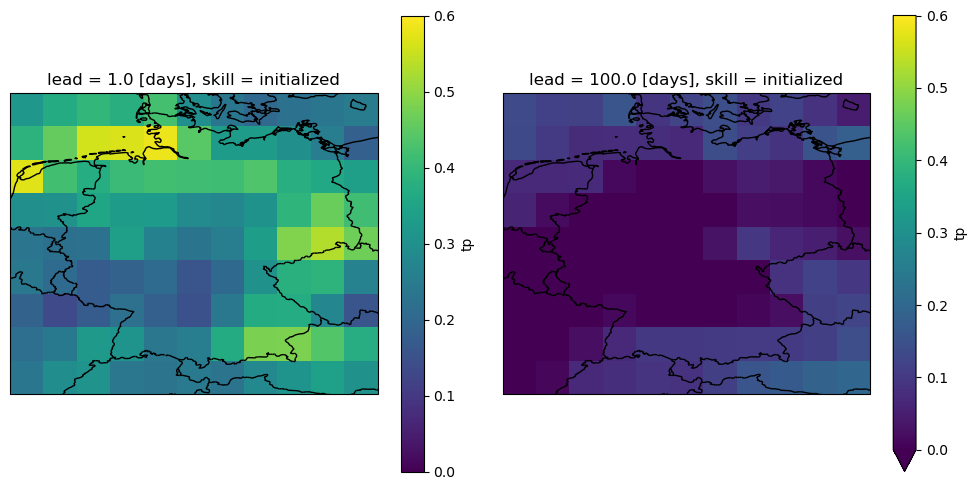

In [65]:
fig, ax = plt.subplots(
    ncols=2, figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)
verification.sel({"lead": 1})["tp"].plot(ax=ax[0], vmin=0, vmax=0.6)
verification.sel({"lead": 100})["tp"].plot(ax=ax[1], vmin=0, vmax=0.6)

for ax in ax.flatten():
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
plt.tight_layout()

In [38]:
verification.dims

Frozen({'lead': 215, 'latitude': 9, 'longitude': 11})

C:\Users\sb123\AppData\Local\Temp\ipykernel_24056\2015482039.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


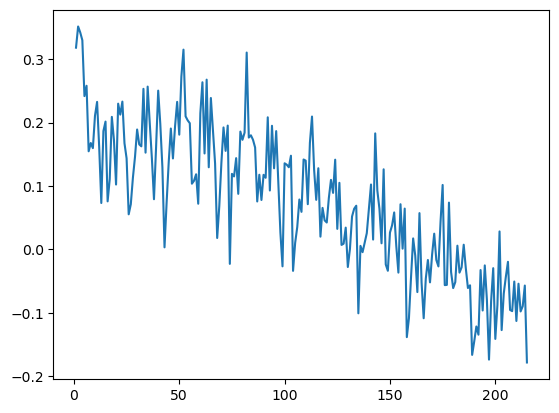

In [33]:
fig, ax = plt.subplots()
y = verification.tp.sel({"longitude": 5, "latitude": 55}).values
x = verification.lead.values
ax.plot(x, y)
fig.show()

# TODO compute manually and compare the graphs!

In [47]:
verification.tp.shape

(215, 9, 11)

C:\Users\sb123\AppData\Local\Temp\ipykernel_24056\4291553736.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


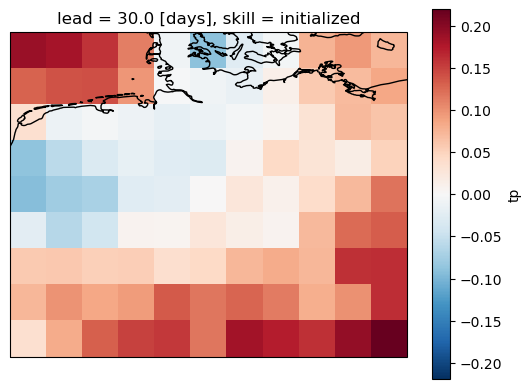

In [46]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
verification.tp.sel({"lead": 30}).plot(ax=ax)
ax.add_feature(cfeature.COASTLINE)
fig.show()

In [39]:
verification.tp.sel({"lead": 30})

<xarray.DataArray 'tp' (latitude: 9, longitude: 11)>
dask.array<getitem, shape=(9, 11), dtype=float64, chunksize=(9, 11), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 5.0 6.0 7.0 8.0 9.0 ... 12.0 13.0 14.0 15.0
  * latitude   (latitude) float32 55.0 54.0 53.0 52.0 51.0 50.0 49.0 48.0 47.0
    lead       float64 30.0
    skill      <U11 'initialized'

# Important points
* [*It’s safest to do anything like climatology removal before constructing climpred objects*](https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html) -> In short, any sort of bias correcting or drift correction can also be done prior to instantiating a PredictionEnsemble object.


# TODO
## Verification
* does data need to be regridded first to common grid?
* try with ERA5 data for now and get skill metrics working in climpred first
*  only thereafter experiment with the HYRAS data and see if you can get it
on the same grid
* If I continue with the HYRAS dataset, check script from Jens

## Bias correction
* https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias
    * how to apply a simple bias correction to the precipitation dataset?
    * it wraps from XCLIM!
    * https://climpred.readthedocs.io/en/stable/bias_removal.html

## Detrending
* https://climpred.readthedocs.io/en/stable/api/climpred.stats.rm_poly.html#climpred.stats.rm_poly
    * detrending
    * or better in XCLIM or straight away in Xarray?
    * see here: https://youtu.be/SKXUBD6DGao?t=563

## EOF analysis
* compute the EOFs
    * https://ajdawson.github.io/eofs/latest/
    * read Wilks chapter

## Parallelisation, dask and numba
* DASK
    * Dask Jupyter Extension for visualisation of tasks
* NUMBA
    * read a bit into Numba, safe for later in job to see if it makes sense,
    recommended [here](https://docs.dask.org/en/latest/array-best-practices.html)
    * speedups vs. scalability

# Weblinks
* Talk by Riley Brady on the module https://youtu.be/EcMxImmMBec?t=8020

# Git
* read and understand Git Pro
* fork climpred
* understand the package
* possibly add to the source code
